In [ ]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

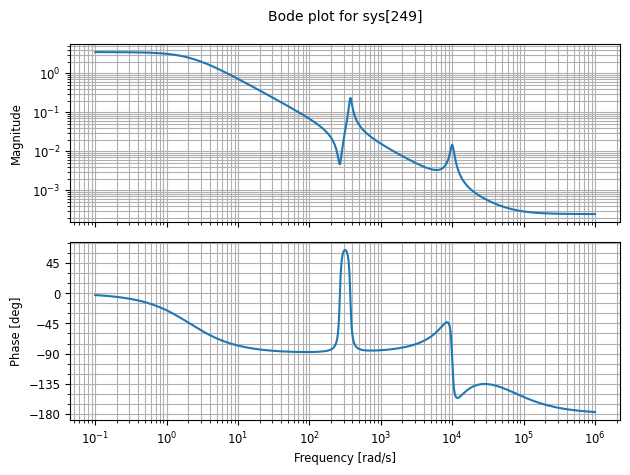

In [21]:
def pt2(omega,zeta):
    return ctrl.tf(omega**2,[1,2*zeta*omega,omega**2])

def notch(omega_n,zeta_n,omega_d,zeta_d):
    return pt2(omega_d,zeta_d)/pt2(omega_n,zeta_n)

def tf_from_txt(fname):
    with open(fname) as f:
        lines = f.readlines()
    
    lines_s = ''.join(lines)

    num_s = lines_s.split(']')[0].strip()
    den_s = lines_s.split(']')[1].strip()

    num_s = num_s.replace('[','').replace(']','').replace('\n','')
    den_s = den_s.replace('[','').replace(']','').replace('\n','')

    num = [float(x) for x in num_s.split()]
    den = [float(x) for x in den_s.split()]
    return ctrl.tf(num,den)

def print_tf(tf,f):
    num = tf.num[0][0]
    den = tf.den[0][0]

    #num = np.flip(num)
    #den = np.flip(den)

    f.write(str(num))
    f.write('\n')
    f.write(str(den))


Gf = tf_from_txt(r'tf_txt\Gf.txt')

ctrl.bode(Gf)


In [22]:
Gf

TransferFunction(array([-2.45755575e-04,  1.20077395e+01,  1.20380740e+05,  1.45058965e+09,
        4.06012480e+10,  1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# IMC Controller

<TransferFunction>: sys[254]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s - 5.888e+04
-------------
      1

No unstable zeros  1
Rel degree: 0
2
0 states have been removed from the model
Reference model (Desired closed loop dynamics)


TransferFunction(array([-3.28524954e+00,  1.93444246e+05]), array([1.00000000e+00, 8.79645943e+02, 1.93444246e+05]))

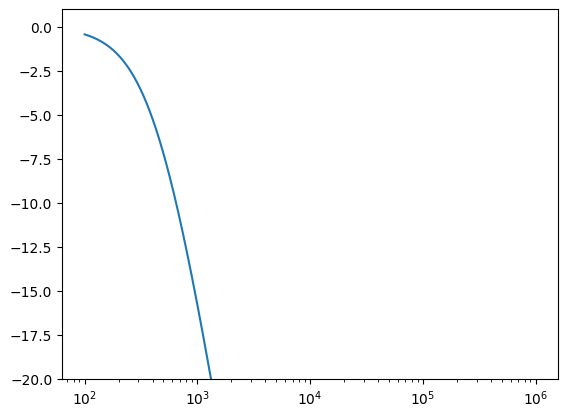

In [24]:


def imc_invert(G):
    # Only invers stable zeros
    zeros = ctrl.zeros(G)

    new_num = ctrl.tf(G.den[0][0],1) # all poles as zeros
    new_den = 1.0

    for z in zeros:

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < 1e-6:
            # real pole     
            p = (s-z)
        else:

            w0 = np.imag(z)
            zeta = -np.real(z)/w0

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        if np.real(z) < 0:
            # stable
            new_den *= p
        else:
            new_num *= p

    G_inv = new_num/new_den
    G_inv = ctrl.minreal(G_inv)

    new_dc_gain = 1/G.dcgain()
    scale = new_dc_gain/G_inv.dcgain()

    G_inv *= scale
    
    return G_inv

def unstable_zeros(G):
    # Only invers stable zeros
    zeros = ctrl.zeros(G)

    new_zeros = 1.0

    for z in zeros:

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < 1e-6:
            # real pole     
            z = np.real(z)
            p = (s-z)
        else:

            w0 = np.imag(z)
            zeta = -np.real(z)/w0

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        if np.real(z) < 0:
            # stable
            #new_den *= p
            pass
        else:
            new_zeros *= p

    
    return new_zeros


unstabl_zers = unstable_zeros(Gf)
print(unstabl_zers)

Ns = len(unstabl_zers.zeros())
print('No unstable zeros ',Ns)

No = len(Gf.poles()) - len(Gf.zeros())
print('Rel degree:',No)

filt_order = No + Ns +1
print(filt_order)

# Ref model
w_cl_m = 70*2*np.pi
M = unstabl_zers / (s/w_cl_m + 1)**filt_order
M = ctrl.minreal(M)
M *= 1/M.dcgain()

plot_mag(M)
plt.ylim([-20,1])
print("Reference model (Desired closed loop dynamics)")
M


In [25]:
def increase_damping(C,min_dampng):

    new_pole_poly = 1.0

    eps = 1e-6

    for z in C.poles():

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < eps:
            # real pole     
            
            z = np.real(z)
            if np.abs(z) > eps:
                p = (s-z)/(-z)
            else:
                p = (s-z)
        elif np.imag(z) > eps:

            w0 = np.imag(z)
            zeta = -np.real(z)/w0

            zeta = max(zeta,min_dampng)

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        new_pole_poly *= p

    zero_poly = ctrl.tf(C.num[0][0],1)
    C_new = zero_poly/new_pole_poly


    gain0 = ctrl.frequency_response(C).response[0][0]
    gain0 = np.mean(np.abs(gain0))

    gain1 = ctrl.frequency_response(C_new).response[0][0]
    gain1 = np.mean(np.abs(gain1))

    C_new *= gain0/gain1


    return C_new


    



3 states have been removed from the model


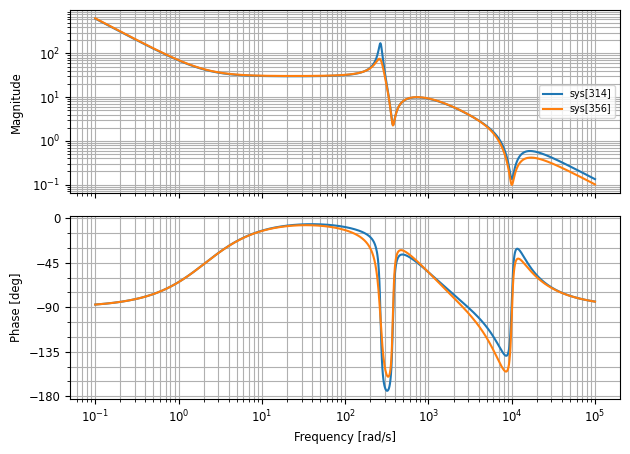

In [26]:
C_imc = M/(1-M) * (1/Gf)
C_imc = ctrl.minreal(C_imc)

ctrl.bode(C_imc)

C_imc = increase_damping(C_imc,0.1)#*1e-14

ctrl.bode(C_imc)


In [27]:

with open(r'tf_txt\C_imc.txt','w') as f:
    print_tf(C_imc,f)


5 states have been removed from the model
6 states have been removed from the model


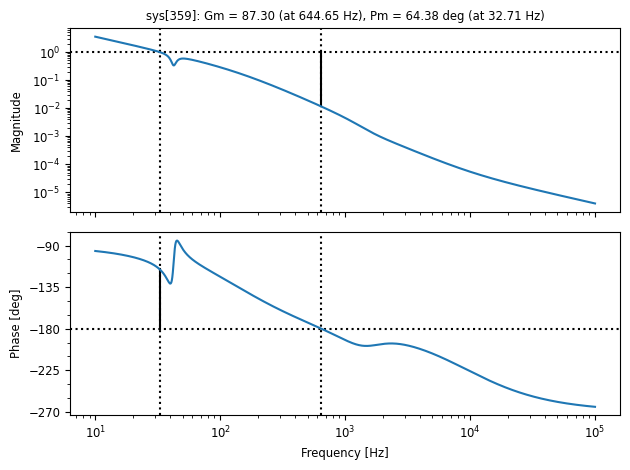

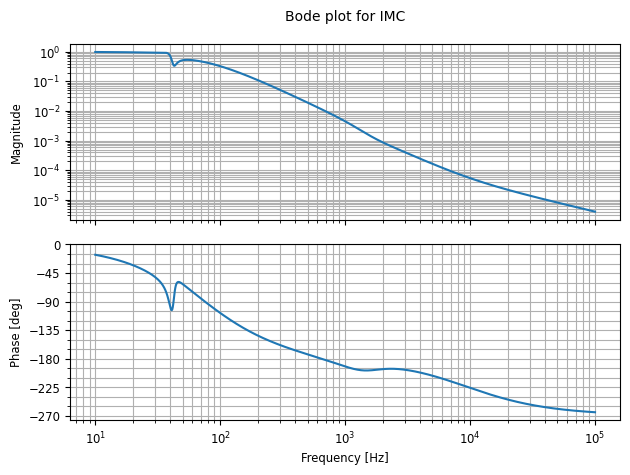

In [28]:
L_imc = C_imc*Gf
L_imc = ctrl.minreal(L_imc)

ctrl.bode(L_imc,display_margins=True,Hz=True)

CL_imc = L_imc/(1+L_imc)
CL_imc = ctrl.minreal(CL_imc)

CL_imc.name = 'IMC'

plt.figure()
ctrl.bode(CL_imc,Hz=True)


0 states have been removed from the model


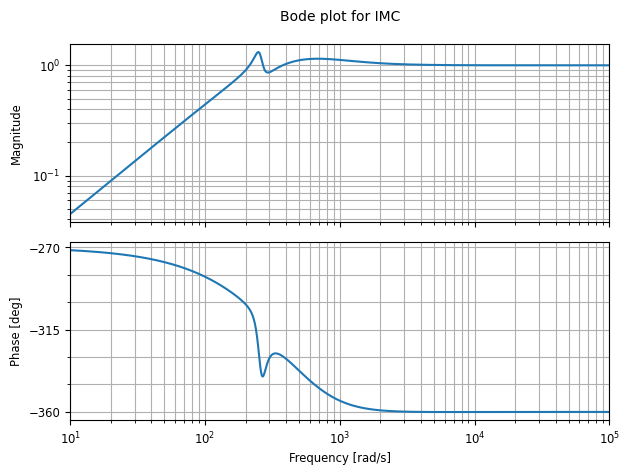

In [29]:


S_imc = 1/(1+L_imc)

S_imc = ctrl.minreal(S_imc)

S_imc.name = 'IMC'

omega_lim = [10,1e5]

ctrl.bode(S_imc,omega_limits=omega_lim)